<a href="https://colab.research.google.com/github/Depersonalizc/AL-cancer-detection/blob/main/Inference_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC4080 Midterm Project - Inference Notebook
## 📝Active Learning for Label-Efficient Histopathologic Cancer Detection


*Group 24* 

- 🐷 CHEN Ang   (118010009)

- 🐸 FU Quanzhi (118010070)

## Prepare Data & Model

In [2]:
# prepare data
!pip install -q --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1gAMjcaut2C3cbWoke8R4vWFQkfoCQX_x
!unzip -q hist_cancer_det.zip -d ./data/
# prepare model
!gdown https://drive.google.com/uc?id=1wagbqJyF-CwNx86I3AkVSbja0lhAtkcm
!unzip -q models.zip -d ./models/
print('Done!')

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Downloading...
From: https://drive.google.com/uc?id=1gAMjcaut2C3cbWoke8R4vWFQkfoCQX_x
To: /content/hist_cancer_det.zip
100% 243M/243M [00:01<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wagbqJyF-CwNx86I3AkVSbja0lhAtkcm
To: /content/models.zip
100% 183M/183M [00:02<00:00, 66.2MB/s]
Done!


In [3]:
# @title Import denpendencies

%matplotlib inline
import pandas as pd
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [43]:
# @title Data preprocessing & augmentation

from torchvision import transforms

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((49, 49)),
    transforms.ToTensor(),
    normalize,
])

def plot_prediction(model, state_dict, id, annotation_file):
  label = ['normal', 'cancer']
  image = valid_transforms(cv2.imread(f"./data/images/{df.id[id]}.tif"))
  base_model.load_state_dict(torch.load(f'./models/{state_dict}.pth'))
  base_model.eval()
  logits = base_model(image.reshape((1,3,49,49)))
  _,predict = torch.max(logits,1)
  plt.figure(figsize=(8,6))
  plt.imshow(cv2.cvtColor(cv2.imread(f"./data/images/{df.id[id]}.tif"), cv2.COLOR_BGR2RGB))
  plt.title(f"Prediction:{label[predict]}\n Truth:{label[df.label[id]]}", fontsize=30)



In [5]:
# @title ResNet50 w/ a binary classification head

from torch import nn
from torchvision import models
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')
resnet = models.resnet50(pretrained=True)

in_features = resnet.fc.in_features
num_hidden = 512

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features=in_features, out_features=num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(in_features=num_hidden, out_features=2),
)

base_model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

Using device cuda:0


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

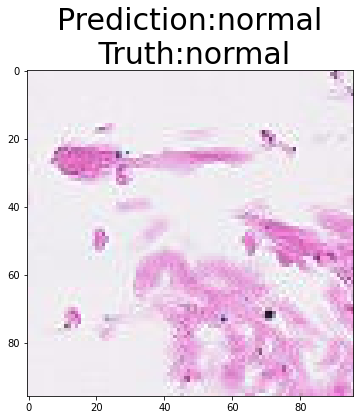

In [46]:
# @title Make Prediction
df = pd.read_csv("./data/labels.csv")
# @markdown Select images in the dataset [number between 0 and 9999]
id =  230 #@param {type: "number"}
image = valid_transforms(cv2.imread(f"./data/images/{df.id[id]}.tif"))
# @markdown Select pre-trained model.
model = 'topconf' # @param ['topconf', 'mcdropout']
plot_prediction(base_model, model, id, df)